<table style="width:100%; border:0" cellspacing="0" cellpadding="0" border="0" align="left|left|right">
  <tr style="border:0">
  <td style="border: 0; font-size:60px" rowspan="3"><b>Universität Bielefeld</b></td>
    <td style="border: 0">CITEC / Faculty of Technology</td>
  </tr>
  <tr style="border:0">
    <td style="border: 0">Multimodal Behavior Processing Group</td>
  </tr>
</table>

## AI Fairness 360 
We will be using AI Fairness 360 for the exercises. The AI Fairness 360 Python package includes a comprehensive set of metrics for datasets and models to test for biases, explanations for these metrics, and algorithms to mitigate bias in datasets and models. 

You can look up more information about the package [here](https://aif360.mybluemix.net/)

## Adult dataset
This dataset is used to predict whether income exceeds $50K/yr. Contains 48842 instances, mix of continuous and discrete features.


In [1]:
from aif360.datasets import AdultDataset 
from aif360.metrics import ClassificationMetric
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
from IPython.display import Markdown, display
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.preprocessing.lfr import LFR
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
            import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas


Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.


In [2]:
# protected features
protected = 'sex'
# privileged class 
privileged_classes = [['Male']]
# Another way to load the dataset
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
ad = load_preproc_data_adult(['sex'])

In [3]:
# print out some labels, names, etc.
display(Markdown("#### Dataset shape"))
print(ad.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(ad.favorable_label, ad.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(ad.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(ad.privileged_protected_attributes, ad.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(ad.feature_names)

#### Dataset shape

(48842, 18)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


In [4]:
ad_df = ad.convert_to_dataframe()[0]

Text(0.5, 1.0, 'Population vs Income')

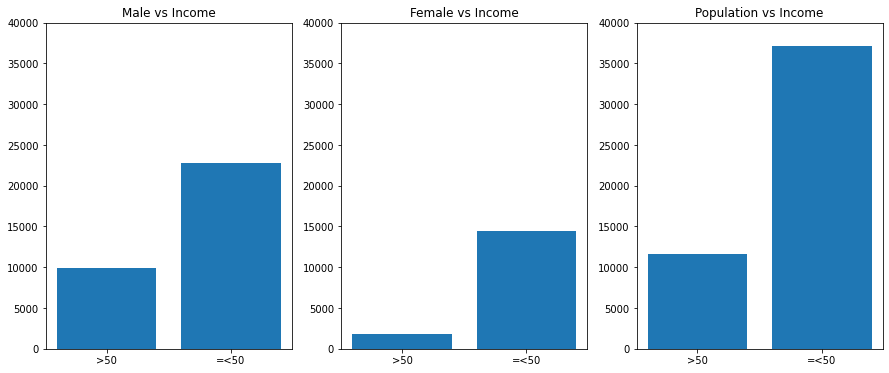

In [5]:
names = ['>50', '=<50']
count = [len(ad_df[ad_df["Income Binary"]==1]), len(ad_df[ad_df["Income Binary"]==0])]
male = ad_df[ad_df['sex']==1]
count_male = [len(male[male["Income Binary"]==1]), len(male[male["Income Binary"]==0])]
female = ad_df[ad_df['sex']==0]
count_female = [len(female[female["Income Binary"]==1]), len(female[female["Income Binary"]==0])]
fig, ax = plt.subplots(1,3, figsize=(15,6))
ax[0].bar(names, count_male)
ax[0].set_ylim(bottom=0, top=40000)
ax[0].set_title("Male vs Income")
ax[1].bar(names, count_female)
ax[1].set_ylim(bottom=0, top=40000)
ax[1].set_title("Female vs Income")
ax[2].bar(names, count)
ax[2].set_ylim(bottom=0, top=40000)
ax[2].set_title("Population vs Income")

In [6]:
# spllt the data into train , valid and test set 
ad_train, ad_test = ad.split([0.7], shuffle = False, seed=0)
ad_valid, ad_test = ad_test.split([0.5], shuffle=False, seed=0)

In [7]:
from collections import OrderedDict, defaultdict
from aif360.metrics import ClassificationMetric
#fucntion provided by aif360 
# helper functions for the task 
def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    # ClassificationMetric is a class that helps you compute all the relavent metrics
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Demographic Parity"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    
    # display the metrics if disp == True
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

def plot(metric_arrs, class_thresh_arr,best_ind, name_set):
    fig, ax = plt.subplots(2,2,figsize=(24,18))

    # plot of Balanced accuracy versus threshold
    ax[0,0].plot(class_thresh_arr, metric_arrs["Balanced accuracy"], color='b')
    ax[0,0].set_title(name_set, fontsize=12, fontweight='bold')
    ax[0,0].set_xlabel('Classification Thresholds', fontsize=12, fontweight='bold')
    ax[0,0].set_ylabel('Balanced Accuracy', color='b', fontsize=12, fontweight='bold')
    ax[0,0].xaxis.set_tick_params(labelsize=12)
    ax[0,0].yaxis.set_tick_params(labelsize=12)
    ax[0,0].legend(["Balanced Accuracy"], fontsize=12)

    # plot of Equalized odds differnce versus threshold
    ax2 = ax[0,0].twinx()
    ax2.plot(class_thresh_arr, metric_arrs["Average odds difference"], color='r')
    ax2.set_ylabel('Equalized odds differnce', color='r', fontsize=12, fontweight='bold')
    ax2.axvline(np.array(class_thresh_arr)[best_ind], 
            color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=12)
    ax2.grid(True)
    ax2.legend(["Equalized odds"], fontsize=12, loc="lower left")

    # plot of Balanced accuracy versus threshold
    ax[0,1].plot(class_thresh_arr, metric_arrs["Balanced accuracy"], color='b')
    ax[0,1].set_title(name_set, fontsize=12, fontweight='bold')
    ax[0,1].set_xlabel('Classification Thresholds', fontsize=12, fontweight='bold')
    ax[0,1].set_ylabel('Balanced Accuracy', color='b', fontsize=12, fontweight='bold')
    ax[0,1].xaxis.set_tick_params(labelsize=12)
    ax[0,1].yaxis.set_tick_params(labelsize=12)
    ax[0,1].legend(["Balanced Accuracy"], fontsize=12)

    # plot of Disparate impact versus threshold
    ax2 = ax[0,1].twinx()
    ax2.plot(class_thresh_arr, metric_arrs["Disparate impact"], color='r')
    ax2.axvline(np.array(class_thresh_arr)[best_ind], 
            color='k', linestyle=':')
    ax2.set_ylabel('Disparate impact', color='r', fontsize=12, fontweight='bold')
    ax2.yaxis.set_tick_params(labelsize=12)
    ax2.grid(True)
    ax2.legend(["Disparate impact"], fontsize=12, loc="lower left")

    # plot of Balanced accuracy versus threshold
    ax[1,0].plot(class_thresh_arr, metric_arrs["Balanced accuracy"], color='b')
    ax[1,0].set_title(name_set, fontsize=12, fontweight='bold')
    ax[1,0].set_xlabel('Classification Thresholds', fontsize=12, fontweight='bold')
    ax[1,0].set_ylabel('Balanced Accuracy', color='b', fontsize=12, fontweight='bold')
    ax[1,0].xaxis.set_tick_params(labelsize=12)
    ax[1,0].yaxis.set_tick_params(labelsize=12)
    ax[1,0].legend(["Balanced Accuracy"], fontsize=12)

    # plot of Equalized opportunity differnce versus threshold
    ax2 = ax[1,0].twinx()
    ax2.plot(class_thresh_arr, metric_arrs["Equal opportunity difference"], color='r')
    ax2.axvline(np.array(class_thresh_arr)[best_ind], 
            color='k', linestyle=':')
    ax2.set_ylabel('Equalized opportunity differnce', color='r', fontsize=12, fontweight='bold')
    ax2.yaxis.set_tick_params(labelsize=12)
    ax2.grid(True)
    ax2.legend(["Equalized opportunity differnce"], fontsize=12, loc="lower left")
    
    fig.delaxes(ax[1][1])

def classifier(classifier, train, valid, test, unprivileged_groups,privileged_groups):
    """
    Applies logistic regression 
    Args:
        train: Traing set
        test: Test set
        threshold: predict a favourable outcome if probabilty >= threshold
    returns:
        Dataset with predictions from the trained classifier 
    """
    
      
    # scalling operation 
    scale = StandardScaler()
    x_train = scale.fit_transform(train.features)
    y_train = train.labels.ravel()
    
    # train the model
    classifier.fit(x_train, y_train)
    
    # find the location of the favorable outcome
    fav_idx = np.where(classifier.classes_ == train.favorable_label)[0][0]      
    
    # prep the data for validation
    valid_pred = valid.copy(deepcopy=True)
    X_valid = scale.fit_transform(valid_pred.features)
    y_valid = valid_pred.labels
    # use the trained model to get the probabilities associated with the favorable outcome
    valid_pred.scores = classifier.predict_proba(X_valid)[:,fav_idx].reshape(-1,1)

    # prep the data for test
    test_pred = test.copy(deepcopy=True)
    X_test = scale.fit_transform(test_pred.features)
    y_test = test_pred.labels
    # use the trained model to get the probabilities associated with the favorable outcome
    test_pred.scores = classifier.predict_proba(X_test)[:,fav_idx].reshape(-1,1)


    num_thresh = 100
    ba_arr = np.zeros(num_thresh)
    # differnt threshold values
    class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

    metric_arrs = defaultdict(list)
    
    # find the best threshold based on balanced accuracy 
    for idx, class_thresh in enumerate(class_thresh_arr):
        # update the labels if the scores are greater than the threshold
        fav_inds = valid_pred.scores > class_thresh
        valid_pred.labels[fav_inds] = valid_pred.favorable_label
        valid_pred.labels[~fav_inds] = valid_pred.unfavorable_label

        
        metric_valid_bef = compute_metrics(valid, valid_pred, 
                                           unprivileged_groups, privileged_groups, disp=False)
        
        
        metric_arrs['Balanced accuracy'].append(metric_valid_bef["Balanced accuracy"])
        metric_arrs['Average odds difference'].append(metric_valid_bef["Average odds difference"])
        metric_arrs['Disparate impact'].append(metric_valid_bef["Disparate impact"])
        metric_arrs['Equal opportunity difference'].append(metric_valid_bef["Equal opportunity difference"])
        
        ba_arr[idx] = metric_valid_bef["Balanced accuracy"]
 
    best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
    best_class_thresh = class_thresh_arr[best_ind]
    print("Optimal classification threshold based on validation set = %.4f" % best_class_thresh)

    # testing the classifier
    # use the best threshold to update the labels for the test set
    fav_inds = test_pred.scores > best_class_thresh
    test_pred.labels[fav_inds] = test_pred.favorable_label
    test_pred.labels[~fav_inds] = test_pred.unfavorable_label
    print("Metrics for the test set:")
    metric_test_bef = compute_metrics(test, test_pred, 
                                       unprivileged_groups, privileged_groups, disp=True)
        
    plot(metric_arrs, class_thresh_arr,best_ind, 'Validation set')


### The general machine learning pipeline consists of  :

    1. Split the dataset into three parts - train, validation and test. 
    
    2. Use the training set to train your model. 
    
    3. Use the validation set to get the best threshold 
    
    4. Evaluate the model on the test set using the threshold from the validation set. 

invalid value encountered in double_scalars


Optimal classification threshold based on validation set = 0.2278
Metrics for the test set:
Balanced accuracy = 0.7498
Demographic Parity = -0.3878
Disparate impact = 0.2765
Average odds difference = -0.3591
Equal opportunity difference = -0.4386
Theil index = 0.1064


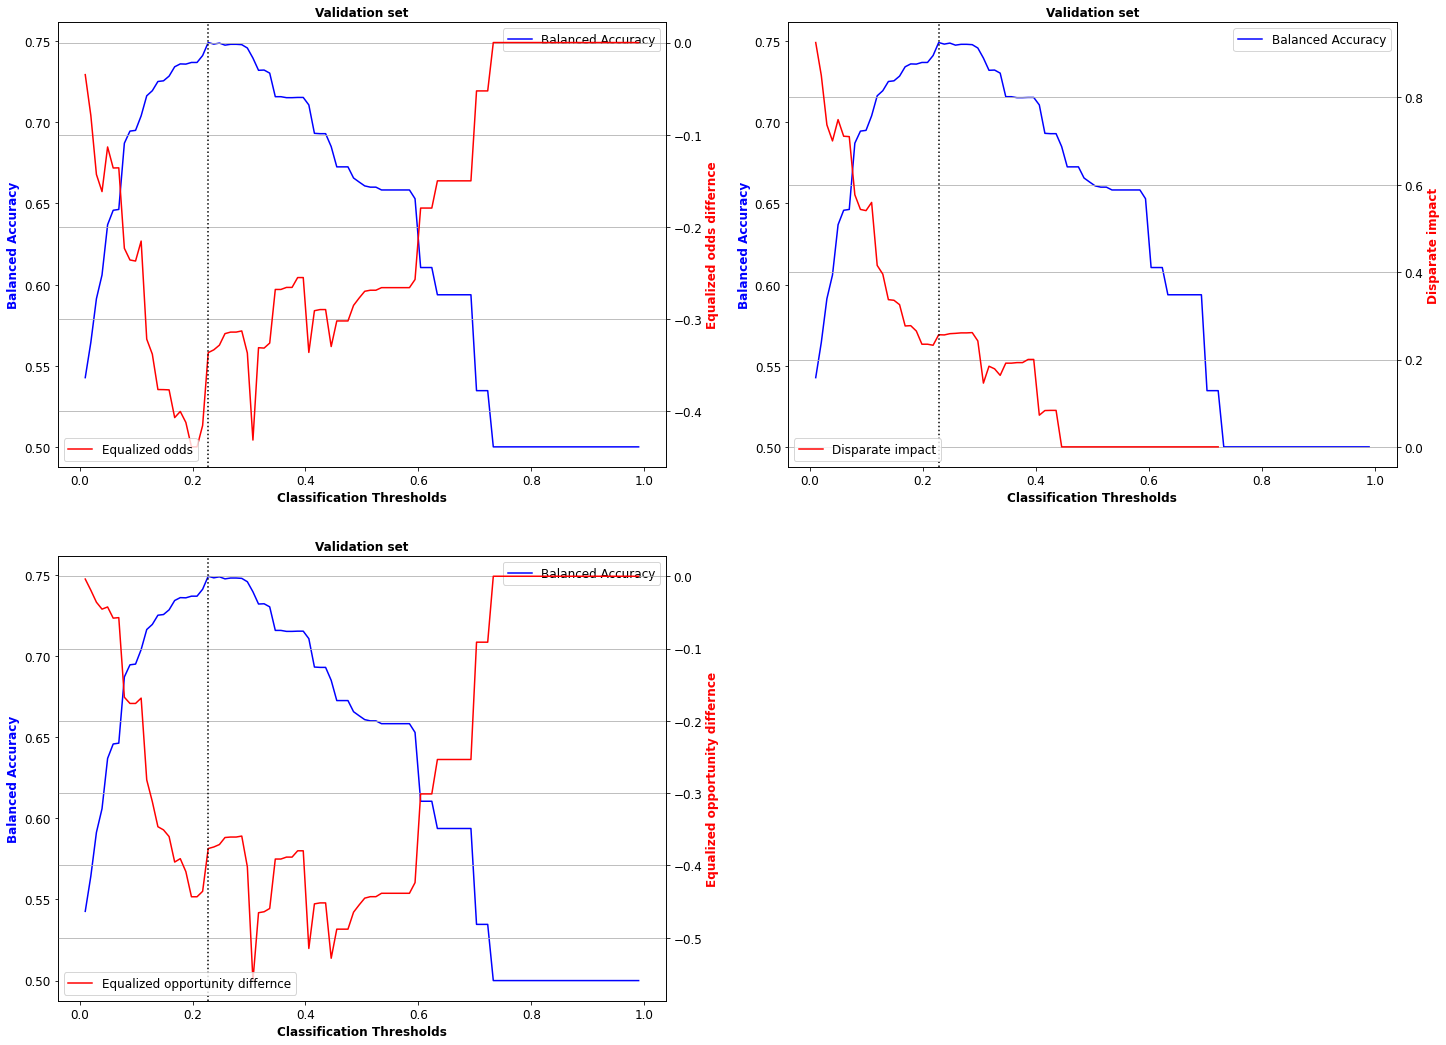

In [8]:
# An exaple for the pipeline 
logistic = LogisticRegression()
classifier(logistic, ad_train, ad_valid, ad_test,unprivileged_groups,privileged_groups)

### Task 2.1: Use a preprocessing technique(Reweighing or Disparate impact remover) for bias mitigation.
Pre-processing algorithms are used to mitigate bias present in the training data. The idea is to apply a preprocessing technique on the training data set and then a apply classification algorithms for learning an appropriate classifier.
You can find the list of all the preprocessing techniques that are available in aif360 [here](https://aif360.readthedocs.io/en/latest/modules/algorithms.html#module-aif360.algorithms.preprocessing)

Also examples of how to use the mitigation techniques can be found [here](https://github.com/Trusted-AI/AIF360/tree/master/examples).

In [9]:
''' 
for this task either use Reweighing or Disparate impact remover as your preprocessing method, then use the preprocessed dataset to train your model(classifier) 

Your approach should be as follows :
1) Uae the preprocessing method to accordingly modify the dataset
2) Use the modified dataset as your training set to learn a classifier
3) Use the validation and test set accordingly to get the results
'''
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing import DisparateImpactRemover

# check the documentation and examples of how to use the techniques 

### Task 2.2: Use a Inprocessing technique(PrejudiceRemover or AdversarialDebiasing impact) for bias mitigation.
Inprocessing techniques try to directly learn a classifier that is both accurate and fair. This can be done in multiple ways such as using adversarial techniques,  applying constraints and regularization. You can find the list of all the inprocessing techniques that are available in aif360 [here](https://aif360.readthedocs.io/en/latest/modules/algorithms.html#module-aif360.algorithms.inprocessing)

Also examples of how to use the mitigation techniques can be found [here](https://github.com/Trusted-AI/AIF360/tree/master/examples)

In [10]:
''' 
for this task either use PrejudiceRemover or AdversarialDebiasing  as your inprocessing method. 

Your approach should be as follows :
2) select an inprocessing technique and train it your training set 
3) Use the validation and test set accordingly to get the results

'''
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing

# check the documentation and examples of how to use the techniques 

### Task 2.3: Explain in your own words the mitigation techniques that you chose to use for the tasks. If there are any hyperparameters associated with the methods, you should include them in your explanation.

You can add your explanations here:

### Task 2.4: Compare the results of the different models (without bias mitigation, with preprocessing, with inprocessing)

You can add your explanations here: *You should use figures or tables to compare the different models. Then follow this up with an a short paragraph explaining your findings*